In [151]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys
import os

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from session_utils import * 

files          = glob.glob('D:/T5_ClosedLoop/*')
click_sessions = get_Sessions(files, min_nblocks = 0, getClick = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


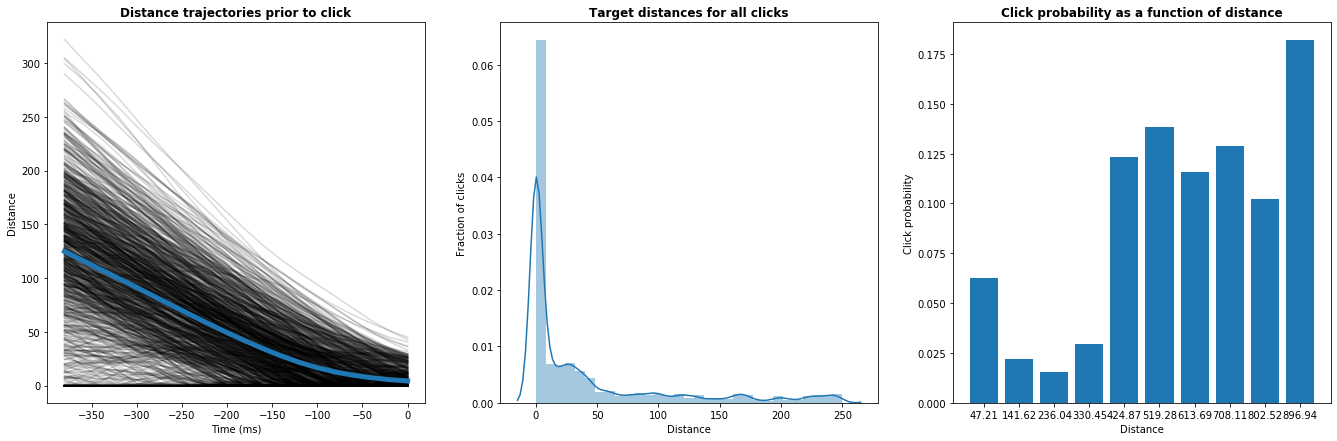

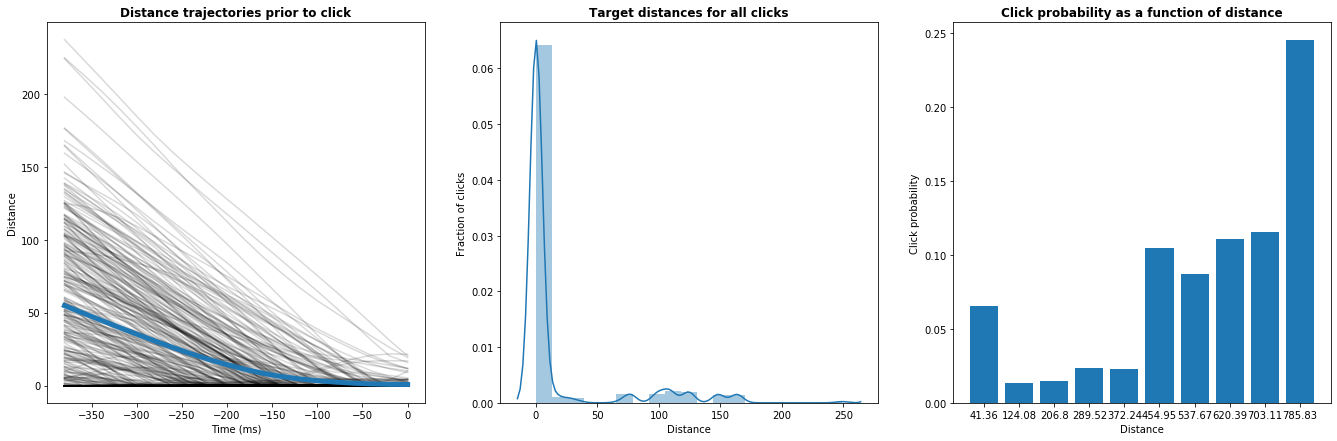

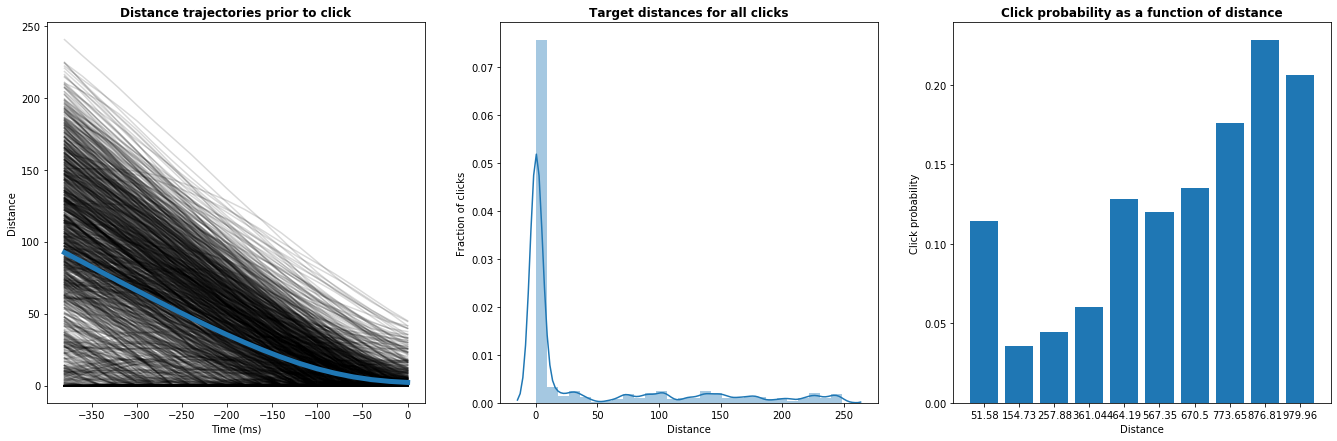

In [52]:
import seaborn as sns
figSize(7, 23)

lookback = 20    # how much earlier prior to clicks to look at (for looking at cursor distance just prior to clicks)
n_bins   = 10    # number of bins to discretize distances for (when calculating click probabilities)
np.random.seed(42)

for i, f in enumerate(np.random.choice(click_sessions, 3, replace = False)):
    #print(np.unique(dat.targetSize))   # hardcoded the targetSize = 50 assumption below, so check valid for all plotted sessions
    dat = DataStruct(f)
    
    plt.figure(i)
    plt.subplot(1, 3, 1)
    plt.title('Distance trajectories prior to click', fontweight = 'bold')
    plt.xlabel('Time (ms)')
    plt.ylabel('Distance')
    dists = list()
    for t in np.where(np.logical_and(dat.decClick_continuous == 1, dat.onTarget == 1))[0]:
        cursor =  dat.cursorPos_continuous[(t - lookback):t, :]
        target =  dat.targetPos_continuous[(t - lookback):t, :]
        dist   = np.maximum(np.linalg.norm(cursor - target, axis = 1) - 50, 0) # distance from target: if within the border set to 0
        dists.append(dist)
        plt.plot(np.arange(-19, 1) * 20, dist, color = 'k', alpha = 0.15)

    plt.plot(np.arange(-19, 1) * 20, np.vstack(dists).mean(axis = 0), linewidth = 5)



    plt.subplot(1, 3, 2)
    plt.title('Target distances for all clicks', fontweight = 'bold')
    plt.xlabel('Distance')
    plt.ylabel('Fraction of clicks')
    alldists    = np.linalg.norm(dat.cursorPos_continuous - dat.targetPos_continuous, axis = 1) 
    click_dists = alldists[dat.decClick_continuous == 1]  # find distance from target for all click times 
    click_dists = click_dists[click_dists < 300]          # remove cases where user continues clicking after trial reset
    click_dists  = np.maximum(click_dists - 50, 0)        # distance from target: if within the border set to 0
    sns.distplot(click_dists, kde_kws= {'bw' : 5})
    
    plt.subplot(1, 3, 3)
    plt.title('Click probability as a function of distance', fontweight = 'bold')
    plt.xlabel('Distance')
    plt.ylabel('Click probability')
    alldists    = np.linalg.norm(dat.cursorPos_continuous - dat.targetPos_continuous, axis = 1) 
    
    dist_bins    = np.linspace(0, alldists.max(), n_bins + 1)
    click_probs  = np.zeros((n_bins,))
    click_labels = np.zeros((n_bins,))
    for j in range(len(dist_bins) - 1):
        bin_pts   = np.logical_and(alldists > dist_bins[j], alldists < dist_bins[j+1])  # all distance times within given discretized bin
        click_pts = np.logical_and(bin_pts, dat.decClick_continuous == 1)
        
        click_probs[j]  = sum(click_pts) / sum(bin_pts)
        click_labels[j] = np.round((dist_bins[j] + dist_bins[j+1]) / 2, 2)
    
    plt.bar(np.arange(len(click_probs)), click_probs)
    plt.xticks(np.arange(len(click_probs)), click_labels)
    
    

Now plot visually on screen all click instances:

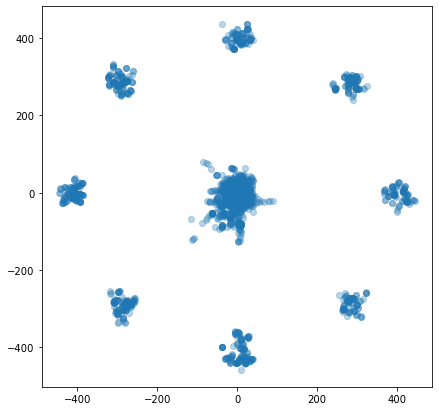

In [161]:
figSize(7, 7)

alldists    = dat.cursorPos_continuous - dat.targetPos_continuous
click_dists = np.linalg.norm(alldists, axis = 1)[dat.decClick_continuous == 1]

click_pos   = alldists[dat.decClick_continuous == 1]

plt.scatter(click_pos[:, 0], click_pos[:, 1], alpha = 0.3)

### **Systematically examine click probabilities**

We'll look at the click probabilies as a function of distance from target, pooling across all click sessions. We get a u-shaped curve where:

- early peak: user clicking on the target
- later peak: user continues clicking after target has moved

In [63]:
n_bins = 20


click_probs  = np.zeros((n_bins, len(click_sessions)))
dist_bins    = np.linspace(0, 1000, n_bins + 1)
click_labels = np.asarray([np.round((dist_bins[j] + dist_bins[j+1]) / 2, 2) for j in range(n_bins)])

for i, f in enumerate(click_sessions):
    dat         = DataStruct(f)
    alldists    = np.linalg.norm(dat.cursorPos_continuous - dat.targetPos_continuous, axis = 1) 
    
    for j in range(len(dist_bins) - 1):
        bin_pts   = np.logical_and(alldists > dist_bins[j], alldists < dist_bins[j+1])  # all distance times within given discretized bin
        click_pts = np.logical_and(bin_pts, dat.decClick_continuous == 1)
        
        click_probs[j, i]  = sum(click_pts) / sum(bin_pts)

Text(0, 0.5, 'Click probability')

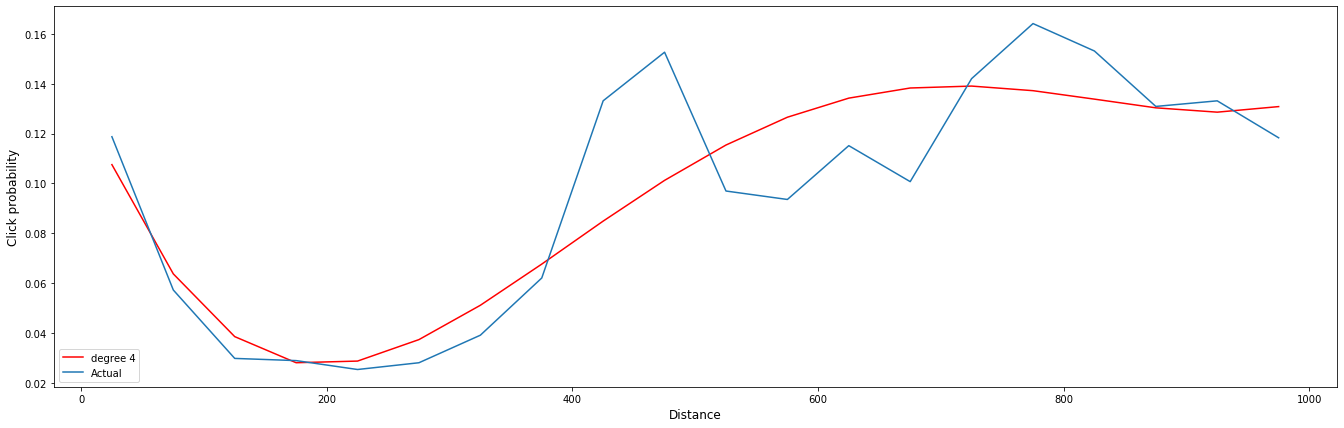

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree   = 4
features = click_labels.reshape(-1, 1)
targets  = np.nanmean(click_probs, axis = 1)

model    = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(features, targets)

    
y_hat = model.predict(features)
plt.plot(features, y_hat, color = 'r', label="degree " + str(degree))
plt.plot(features, targets, label = 'Actual')

plt.legend(loc='lower left')
plt.xlabel('Distance', fontsize = 12)
plt.ylabel('Click probability', fontsize = 12)

In [145]:
def f(x):
    x_mat         = np.vstack([x**i for i in range(5)])    
    coefs         = [ 0.00000000e+00, -1.33178954e-03,  5.05269183e-06, -6.29799392e-09, 2.57353522e-12]
    out           = x_mat.T.dot(coefs) + 0.13775515475153405
    out[x > 1000] = .12
    
    return out
    

(5, 20)


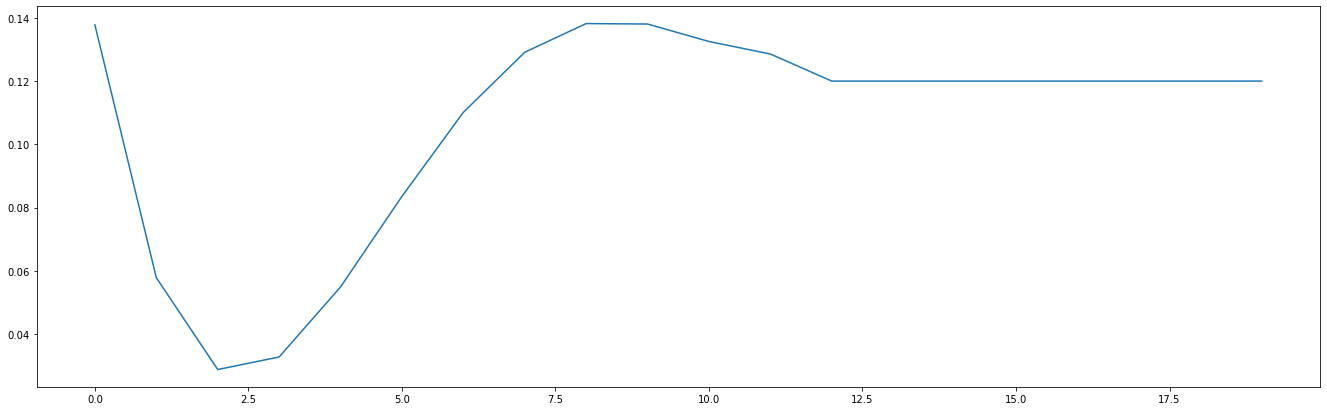

In [146]:
x = np.concatenate(np.linspace(0, 1600, 20).reshape(-1, 1))

plt.plot(f(x))